In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dsdl
import numpy.random
from typing import Callable, List
import pandas as pd
import json
import os

%load_ext autoreload
%autoreload 2
from regression.reg import LossType

# Logistic regression

In [2]:
from optimizers.Optimizer import Optimizer

In [3]:
DATA_DIR = 'data/'

def get_data(dataset_filename: str):
    """
    Loads dataset from csv file. The last column must represent the target variable.
    :param dataset_filename: Filename of the dataset from dsdl module.
    :return: (X, y) feature and target data.
    """
    filepath = os.path.join(DATA_DIR, dataset_filename)
    df = pd.read_csv(filepath)
    return df.iloc[:,:-1].values, df.iloc[:,-1].values.reshape(-1, 1)

def build_model(X, y):
    """
    Joins weights
    :param X: shape=(N, D). Train data
    :param y: shape=(N, 1). Target data
    :return: shape=(N, D+1). Built model for logistic regression.
    """
    return np.c_[np.zeros((y.shape[0], 1)), X]

def get_initial_weights(tx):
    """
    Returns weights initialized from the uniform distribution [0, 1].
    :param tx: shape=(N, D). Build model
    :return: shape=(D, 1) Initial weights
    """
    np.random.seed(2022)
    return np.zeros(shape=(tx.shape[1], 1))

def test_method(method: Optimizer,
                initial_weights,
                tx,
                y,
                max_iter: int,
                loss_type,
                *parameter):
        """
        :param method: Optimization method implementation from src optimizers module.
        :param dataset_name: Name of the dataset from dsdl module.
        :param max_iter: Number of iterations to test.
        :param parameters optional: Dataclass containing parameters used int optimization method.
        :return: List of gradients from optimization method.
        """
        gradients, loss = method.optimize(initial_weights, tx, y, max_iter, loss_type)
        return [np.linalg.norm(grad, 2) for grad in gradients], loss

In [4]:
from optimizers.SGD import SGD
from optimizers.AdaGrad import AdaGrad
from optimizers.RMSProp import RMSProp

In [5]:
DATASETS = ['housing.csv']  #'diabetes.csv',
LOSS_TYPES = [LossType.MAE, LossType.MSE]

METHODS = [
    AdaGrad(lambda_=0.0001, epsilon= 0.0001),
    SGD(lambda_=0.0001),
    RMSProp(lambda_=0.0001, decay_rate_=0.9, epsilon=0.0001)
]

1. Przeprowadzić testy lambda [0.0001, 0.001, 0.01]
2. Wybrać najlepszy parametr lambda i przeprowadzić testy decay_rate_

## Run simulations

In [6]:
ITERATIONS = 500000
N_RUNS = 3

all_gradients = []

datasets_data = {}
for i, dataset_name in enumerate(DATASETS):

    print("Dataset", dataset_name)

    X, y = get_data(dataset_name)
    tx = build_model(X, y)
    initial_weights = get_initial_weights(tx)

    methods_data = {}
    loss_data = {}
    for method in METHODS:
        for loss_type in LOSS_TYPES:
            print("Method: ", method.name, ", loss: ", loss_type)

            gradients_5_runs = list()
            losses_5_runs = list()
            for _ in range(N_RUNS):
                gradients, losses = test_method(method, initial_weights, tx, y, ITERATIONS, loss_type)
                # save gradients and losses
                gradients_5_runs.append(gradients)
                losses_5_runs.append(losses)

            # calculate mean of gradients and loses
            gradients_mean = np.mean(gradients_5_runs, axis=0)
            gradients_stddev = np.std(gradients_5_runs, axis=0)
            gradients_lower = gradients_mean - gradients_stddev
            gradients_upper = gradients_mean + gradients_stddev

            # calculate mean of gradients and loses
            losses_mean = np.mean(losses_5_runs, axis=0)
            losses_stddev = np.std(losses_5_runs, axis=0)
            losses_lower = losses_mean - losses_stddev
            losses_upper = losses_mean + losses_stddev

            methods_data[method.name] = {
                "gradient_mean": list(gradients_mean),
                "gradient_lower": list(gradients_lower),
                "gradient_upper": list(gradients_upper),
                "losses_mean": list(losses_mean),
                "losses_lower": list(losses_lower),
                "losses_upper": list(losses_upper),
                "n_runs": N_RUNS,
                "loss_type": loss_type.name,
                "n_iterations": ITERATIONS
            }
            loss_data[loss_type.name] = methods_data
            datasets_data[dataset_name] = loss_data

Dataset housing.csv
Method:  AdaGrad , loss:  LossType.MAE
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
Method:  AdaGrad , loss:  LossType.MSE
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
Method:  SGD , loss:  LossType.MAE
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
Method:  SGD , loss:  LossType.MSE
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
Method:  RMSProp , loss:  LossType.MAE
0
50000
100000
150000
200

In [6]:
methods_colors = {
    "SGD": "blue",
    "AdaGrad": "purple",
    "RMSProp": "orange"
}

### Load run file, if needed

In [7]:
with open('D:\parameters_sweep_lambda_0_0001_housing.json', 'w') as file:
    json.dump(datasets_data, file)

In [25]:
with open('D:\parameters_sweep_lambda_0_0001_diabetes.json', 'r') as f:
    datasets_data_diabetes = json.load(f)

In [8]:
def get_shorter_array(data, each):
    data = np.array(data).reshape(int(len(data)/each), each)
    return np.mean(data, axis=1)

In [28]:
datasets_data['diabetes.csv'] = datasets_data_diabetes['diabetes.csv']
del datasets_data_diabetes

### Plot gradients

Dataset housing.csv
Loss MAE
Method AdaGrad
Method SGD
Method RMSProp
Loss MSE
Method AdaGrad
Method SGD
Method RMSProp
Dataset diabetes.csv
Loss MAE
Method AdaGrad
Method SGD
Method RMSProp
Loss MSE
Method AdaGrad
Method SGD
Method RMSProp


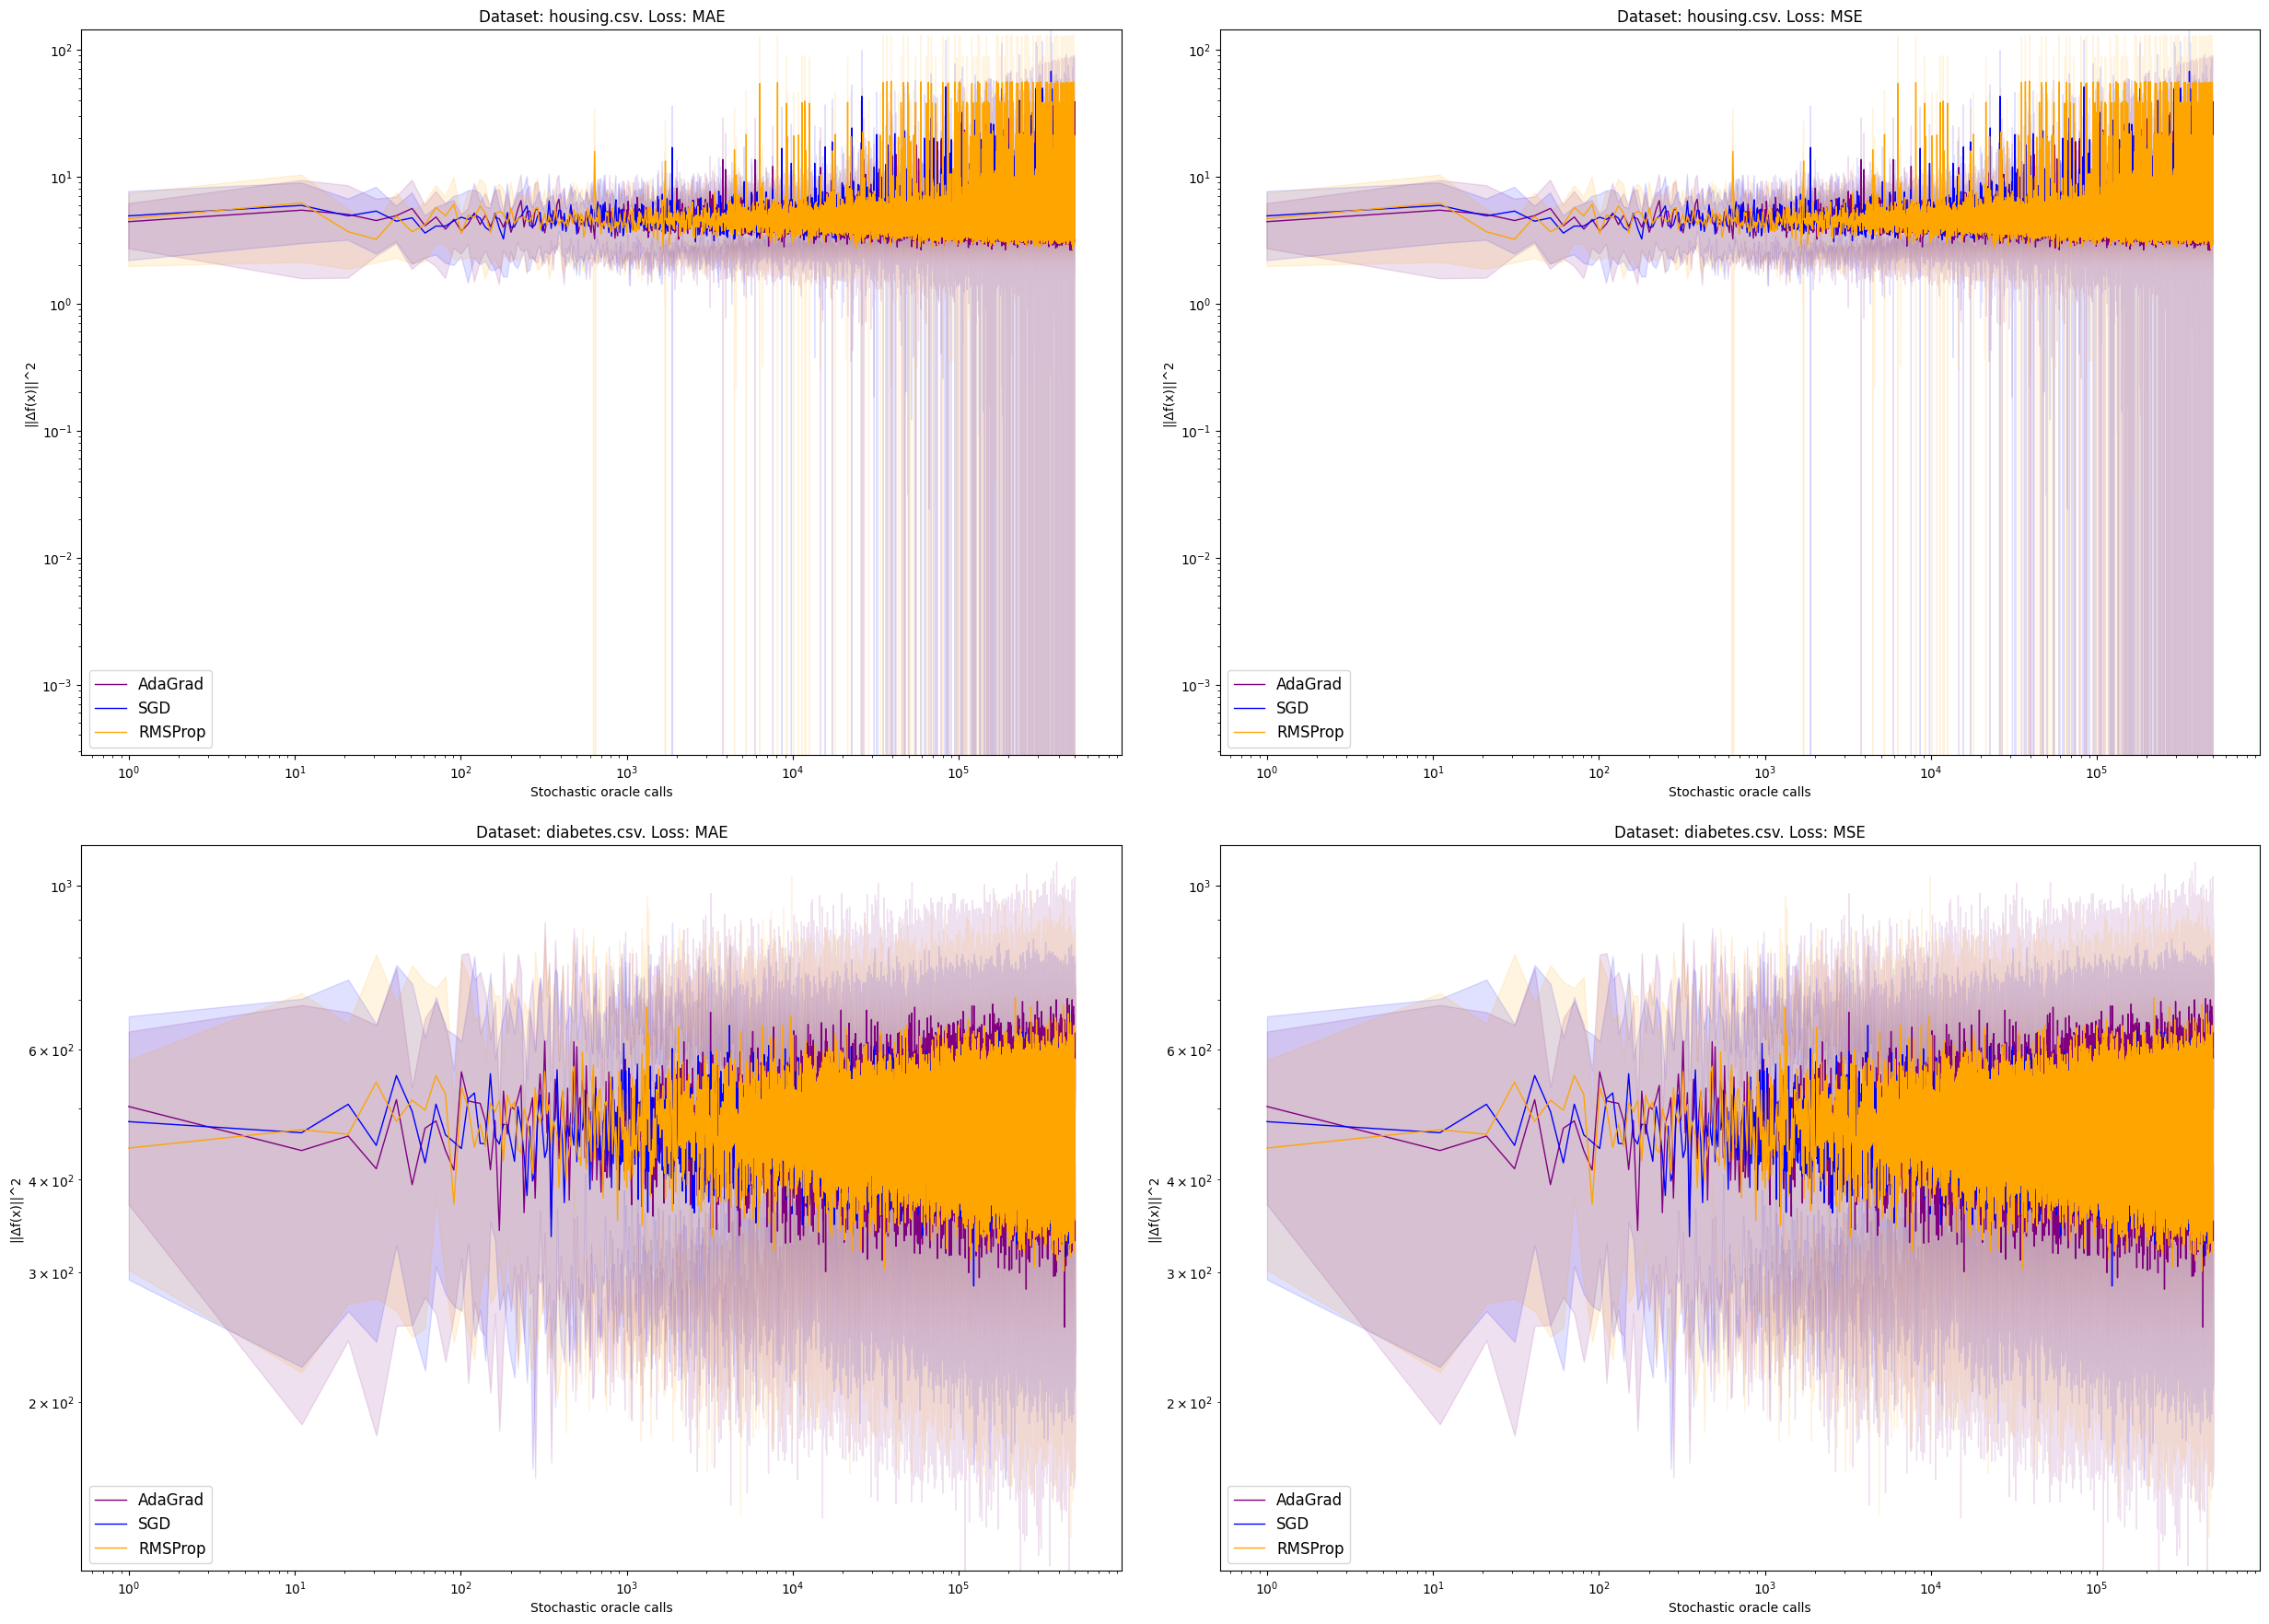

In [36]:
X_LABEL = "Stochastic oracle calls"
Y_LABEL = "||\u0394f(x)||^2"

fig, ax = plt.subplots(2, 2, figsize=(25, 18), sharey=False, sharex=False)

for i, (dataset_name, losses_data)  in enumerate(datasets_data.items()):
    print("Dataset", dataset_name)

    for k, (loss_name, methods_data) in enumerate(losses_data.items()):
        print("Loss", loss_name)

        sbplt = ax[i%2, k%2]
        for method_name, method_data in methods_data.items():
            print("Method", method_name)

            method_color = methods_colors[method_name]
            gradients_mean = method_data['gradient_mean']
            lower = method_data['gradient_lower']
            upper = method_data['gradient_upper']
            n_iterations = method_data['n_iterations']

            EACH = 10
            gradients_mean = get_shorter_array(gradients_mean, EACH)
            lower = get_shorter_array(lower, EACH)
            upper = get_shorter_array(upper, EACH)

            grad_x = [(EACH*n)+1 for n in range(len(gradients_mean))]

            sbplt.plot(grad_x, gradients_mean, label=method_name,
                       linewidth=1, color=method_color)

            sbplt.fill_between(grad_x, lower, upper, alpha=0.12,
                               facecolor=method_color, edgecolor=method_color)

            sbplt.set_ylim(0.9*min(abs(lower)), 1.1*max(upper))
            sbplt.set_xscale('log')
            sbplt.set_yscale('log')
            sbplt.set_title(f"Dataset: {dataset_name}. Loss: {loss_name}")
            sbplt.set_xlabel(X_LABEL)
            sbplt.set_ylabel(Y_LABEL)
            sbplt.legend(loc='lower left', fontsize='large')
fig.tight_layout(pad=2.0)
plt.savefig("lambda_0_0001_each_10_gradients.png")
plt.show()

### Plot loss

Dataset housing.csv
Loss MAE
Method AdaGrad
Method SGD
Method RMSProp
Loss MSE
Method AdaGrad
Method SGD
Method RMSProp
Dataset diabetes.csv
Loss MAE
Method AdaGrad
Method SGD
Method RMSProp
Loss MSE
Method AdaGrad
Method SGD
Method RMSProp


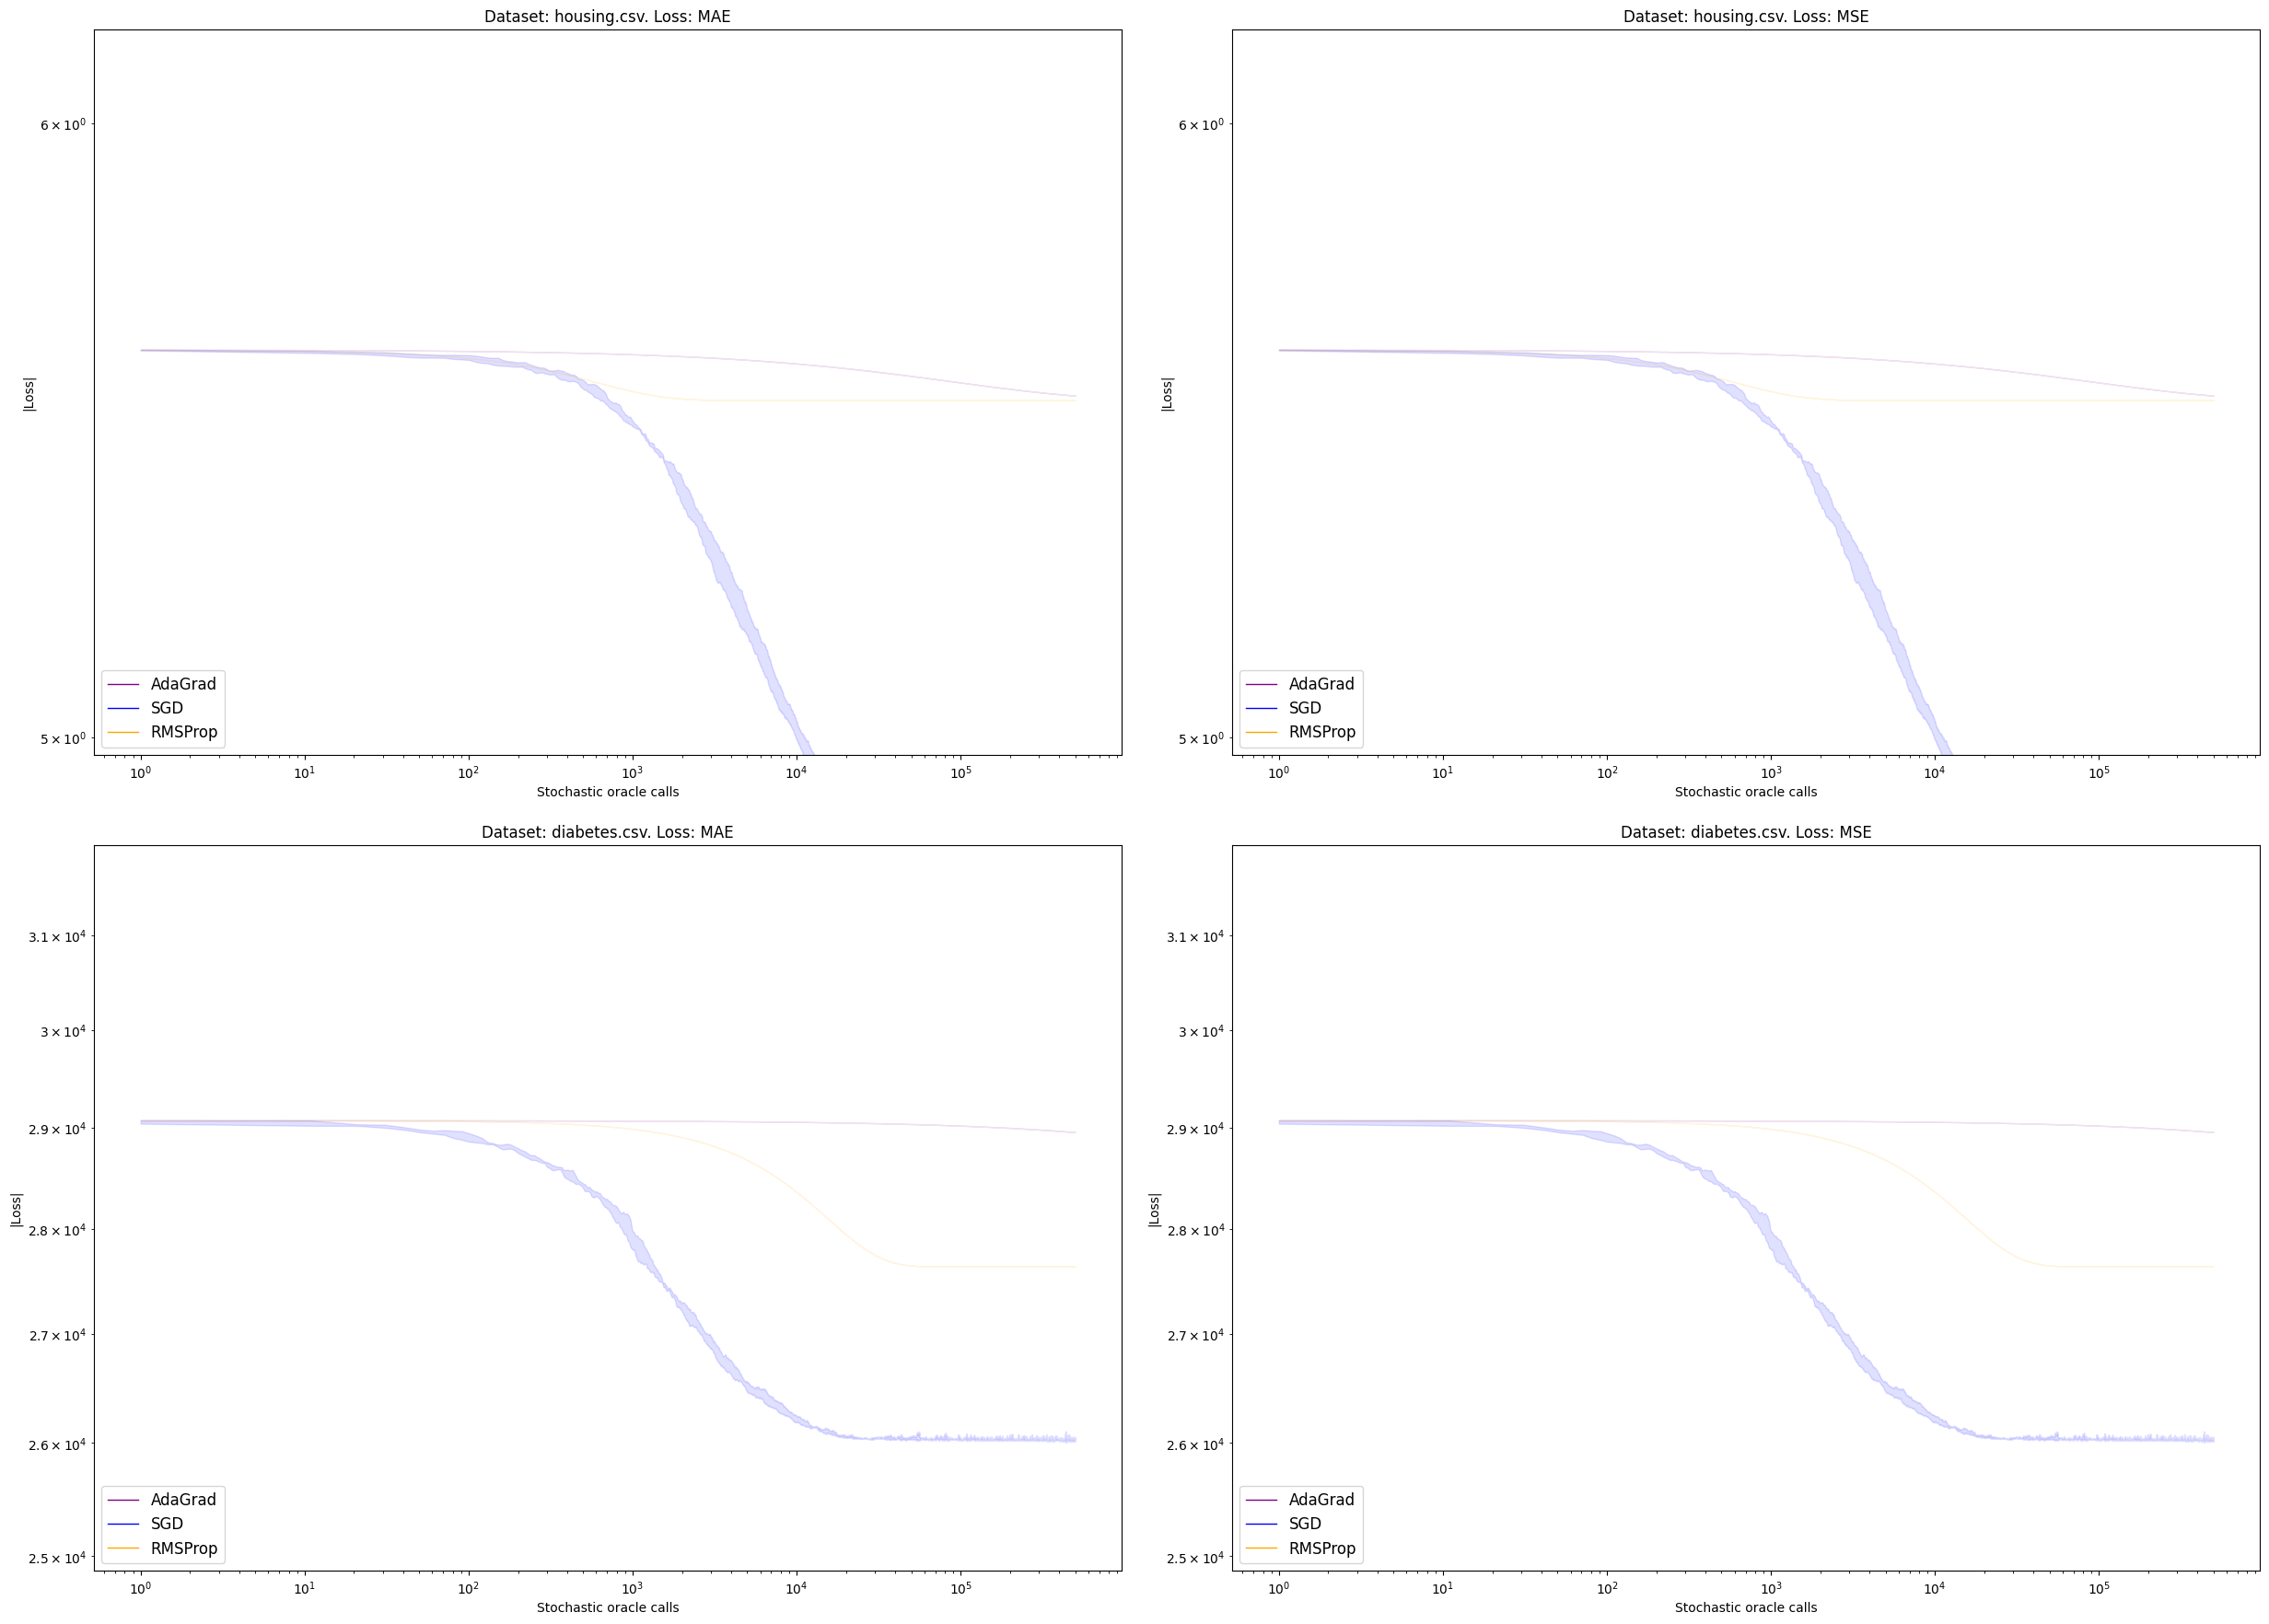

In [40]:
X_LABEL = "Stochastic oracle calls"
Y_LABEL = "|Loss|"

fig, ax = plt.subplots(2, 2, figsize=(25, 18), sharey=False, sharex=False)

for i, (dataset_name, losses_data)  in enumerate(datasets_data.items()):
    print("Dataset", dataset_name)

    for k, (loss_name, methods_data) in enumerate(losses_data.items()):
        print("Loss", loss_name)

        sbplt = ax[i%2, k%2]
        for method_name, method_data in methods_data.items():
            print("Method", method_name)

            method_color = methods_colors[method_name]
            losses_mean = method_data['losses_mean']
            lower = method_data['losses_lower']
            upper = method_data['losses_upper']
            n_iterations = method_data['n_iterations']

            EACH = 10
            losses_mean = get_shorter_array(losses_mean, EACH)
            lower = get_shorter_array(lower, EACH)
            upper = get_shorter_array(upper, EACH)

            grad_x = [(EACH*n)+1 for n in range(len(gradients_mean))]

            sbplt.plot(grad_x, gradients_mean, label=method_name,
                       linewidth=1, color=method_color)

            sbplt.fill_between(grad_x, lower, upper, alpha=0.12,
                               facecolor=method_color, edgecolor=method_color)

            sbplt.set_ylim(0.9*min(abs(lower)), 1.1*max(upper))
            sbplt.set_xscale('log')
            sbplt.set_yscale('log')
            sbplt.set_title(f"Dataset: {dataset_name}. Loss: {loss_name}")
            sbplt.set_xlabel(X_LABEL)
            sbplt.set_ylabel(Y_LABEL)
            sbplt.legend(loc='lower left', fontsize='large')
fig.tight_layout(pad=2.0)
plt.savefig("lambda_0_0001_each_10_losses.png")
plt.show()